In [1]:
!python -m pip install pyyaml==5.1
import sys, os, distutils.core
# Note: This is a faster way to install detectron2 in Colab, but it does not include all functionalities (e.g. compiled operators).
# See https://detectron2.readthedocs.io/tutorials/install.html for full installation instructions
!git clone 'https://github.com/facebookresearch/detectron2'
dist = distutils.core.run_setup("./detectron2/setup.py")
!python -m pip install {' '.join([f"'{x}'" for x in dist.install_requires])}
sys.path.insert(0, os.path.abspath('./detectron2'))

# Properly install detectron2. (Please do not install twice in both ways)
# !python -m pip install 'git+https://github.com/facebookresearch/detectron2.git'

  Using cached PyYAML-5.1.tar.gz (274 kB)
  error: subprocess-exited-with-error
  
  × python setup.py egg_info did not run successfully.
  │ exit code: 1
  ╰─> See above for output.
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
  Preparing metadata (setup.py) ... error
error: metadata-generation-failed

× Encountered error while generating package metadata.
╰─> See above for output.

note: This is an issue with the package mentioned above, not pip.
hint: See above for details.
fatal: destination path 'detectron2' already exists and is not an empty directory.
Ignoring dataclasses: markers 'python_version < "3.7"' don't match your environment


In [2]:
import torch, detectron2
!nvcc --version
TORCH_VERSION = ".".join(torch.__version__.split(".")[:2])
CUDA_VERSION = torch.__version__.split("+")[-1]
print("torch: ", TORCH_VERSION, "; cuda: ", CUDA_VERSION)
print("detectron2:", detectron2.__version__)

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2023 NVIDIA Corporation
Built on Tue_Aug_15_22:02:13_PDT_2023
Cuda compilation tools, release 12.2, V12.2.140
Build cuda_12.2.r12.2/compiler.33191640_0
torch:  2.4 ; cuda:  cu121
detectron2: 0.6


In [3]:
# Some basic setup:
# Setup detectron2 logger
import detectron2
from detectron2.utils.logger import setup_logger
setup_logger()

# import some common libraries
import numpy as np
import os, json, cv2, random
from google.colab.patches import cv2_imshow
from matplotlib import pyplot as plt

# import some common detectron2 utilities
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog, DatasetCatalog
from detectron2.data.datasets import register_coco_instances

In [4]:
register_coco_instances("my_dataset_train", {}, "/kaggle/input/coco-dataset-3/dataset/train/_annotations.coco.json", "/kaggle/input/coco-dataset-3/dataset/train")
register_coco_instances("my_dataset_val", {}, "/kaggle/input/coco-dataset-3/dataset/valid/_annotations.coco.json", "/kaggle/input/coco-dataset-3/dataset/valid")
register_coco_instances("my_dataset_test", {}, "/kaggle/input/coco-dataset-3/dataset/test/_annotations.coco.json", "/kaggle/input/coco-dataset-3/dataset/test")

In [5]:
train_metadata = MetadataCatalog.get("my_dataset_train")
train_dataset_dicts = DatasetCatalog.get("my_dataset_train")

[12/24 08:57:51 d2.data.datasets.coco]: Loaded 2298 images in COCO format from /kaggle/input/coco-dataset-3/dataset/train/_annotations.coco.json


In [6]:
val_metadata = MetadataCatalog.get("my_dataset_val")
val_dataset_dicts = DatasetCatalog.get("my_dataset_val")

[12/24 08:57:53 d2.data.datasets.coco]: Loaded 216 images in COCO format from /kaggle/input/coco-dataset-3/dataset/valid/_annotations.coco.json


In [7]:
test_metadata = MetadataCatalog.get("my_dataset_test")
test_dataset_dicts = DatasetCatalog.get("my_dataset_test")

[12/24 08:57:54 d2.data.datasets.coco]: Loaded 72 images in COCO format from /kaggle/input/coco-dataset-3/dataset/test/_annotations.coco.json


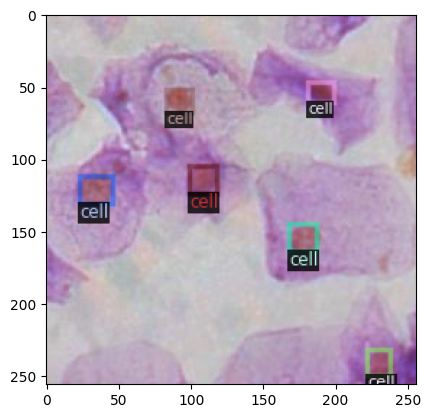

In [27]:
# Visualize some random samples
for d in random.sample(train_dataset_dicts, 1):
    img = cv2.imread(d["file_name"])
    visualizer = Visualizer(img[:, :, ::-1], metadata=train_metadata, scale=1)
    vis = visualizer.draw_dataset_dict(d)
    plt.imshow(vis.get_image()[:, :, ::-1])
    plt.show()

# Train

In [28]:
from detectron2.engine import DefaultTrainer

cfg = get_cfg()
cfg.OUTPUT_DIR = "/kaggle/working/models/Detectron2_Models"
cfg.merge_from_file(model_zoo.get_config_file("COCO-Detection/faster_rcnn_R_101_FPN_3x.yaml"))
cfg.DATASETS.TRAIN = ("my_dataset_train",)
cfg.DATASETS.TEST = ()
cfg.DATALOADER.NUM_WORKERS = 2
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-Detection/faster_rcnn_R_101_FPN_3x.yaml")  # Let training initialize from model zoo
cfg.SOLVER.IMS_PER_BATCH = 2  # This is the real "batch size" commonly known to deep learning people
cfg.SOLVER.BASE_LR = 0.00025  # pick a good LR
cfg.SOLVER.MAX_ITER = 1000    # 1000 iterations seems good enough for this dataset
cfg.SOLVER.STEPS = []        # do not decay learning rate
cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 256   # Default is 512, using 256 for this dataset.
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 1  # We have 1 class (cell)
# NOTE: this config means the number of classes, without the background. Do not use num_classes+1 here.

os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)
trainer = DefaultTrainer(cfg) #Create an instance of of DefaultTrainer with the given congiguration
trainer.resume_or_load(resume=False) #Load a pretrained model if available (resume training) or start training from scratch if no pretrained model is available

[12/24 09:13:27 d2.engine.defaults]: Model:
GeneralizedRCNN(
  (backbone): FPN(
    (fpn_lateral2): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelMaxPool()
    (bottom_up): ResNet(
      (stem): BasicStem(
        (conv1): Conv2d(
          3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
      )
      (res

model_final_f6e8b1.pkl: 243MB [00:01, 209MB/s]                             


In [29]:
trainer.train() #Start the training process

[12/24 09:13:48 d2.engine.train_loop]: Starting training from iteration 0


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


[12/24 09:13:58 d2.utils.events]:  eta: 0:00:39  iter: 19  total_loss: 3.199  loss_cls: 0.6167  loss_box_reg: 0.6038  loss_rpn_cls: 1.758  loss_rpn_loc: 0.1493    time: 0.4964  last_time: 0.5648  data_time: 0.0120  last_data_time: 0.0054   lr: 4.7703e-05  max_mem: 3626M
[12/24 09:14:09 d2.utils.events]:  eta: 0:00:29  iter: 39  total_loss: 1.608  loss_cls: 0.5383  loss_box_reg: 0.6363  loss_rpn_cls: 0.3307  loss_rpn_loc: 0.172    time: 0.5051  last_time: 0.4593  data_time: 0.0051  last_data_time: 0.0050   lr: 9.7653e-05  max_mem: 3626M
[12/24 09:14:19 d2.utils.events]:  eta: 0:00:19  iter: 59  total_loss: 1.509  loss_cls: 0.4323  loss_box_reg: 0.6964  loss_rpn_cls: 0.1671  loss_rpn_loc: 0.1252    time: 0.5078  last_time: 0.5032  data_time: 0.0049  last_data_time: 0.0047   lr: 0.0001476  max_mem: 3626M
[12/24 09:14:28 d2.utils.events]:  eta: 0:00:09  iter: 79  total_loss: 1.356  loss_cls: 0.3545  loss_box_reg: 0.7532  loss_rpn_cls: 0.1146  loss_rpn_loc: 0.1797    time: 0.4981  last_time

In [30]:
import yaml
# Save the configuration to a config.yaml file
config_yaml_path = "/kaggle/working/models/Detectron2_Models/config.yaml"
with open(config_yaml_path, 'w') as file:
    yaml.dump(cfg, file)

In [31]:
# Inference should use the config with parameters that are used in training
# cfg now already contains everything we've set previously. We changed it a little bit for inference:
cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final.pth")  # path to the model we just trained
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.5   # set a custom testing threshold
predictor = DefaultPredictor(cfg)

[12/24 09:14:46 d2.checkpoint.detection_checkpoint]: [DetectionCheckpointer] Loading from /kaggle/working/models/Detectron2_Models/model_final.pth ...


/usr/local/lib/python3.10/dist-packages/fvcore/common/checkpoint.py:252: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return torch.load(f, map_location=torch.device("cpu"))

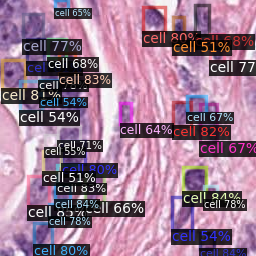

In [48]:
from detectron2.utils.visualizer import ColorMode

for d in random.sample(val_dataset_dicts, 1):    #select number of images for display
    im = cv2.imread(d["file_name"])
    outputs = predictor(im)
    instances = outputs["instances"].to("cpu")
    v = Visualizer(im[:, :, ::-1],
                   metadata=val_metadata,
                   scale=1
    )
    out = v.draw_instance_predictions(instances)
    cv2_imshow(out.get_image()[:, :, ::-1])

In [33]:
from detectron2.evaluation import COCOEvaluator, inference_on_dataset
from detectron2.data import build_detection_test_loader
evaluator = COCOEvaluator("my_dataset_val", output_dir="./output")
val_loader = build_detection_test_loader(cfg, "my_dataset_val")
print(inference_on_dataset(predictor.model, val_loader, evaluator))
# another equivalent way to evaluate the model is to use `trainer.test`

[12/24 09:15:04 d2.evaluation.coco_evaluation]: Fast COCO eval is not built. Falling back to official COCO eval.
[12/24 09:15:04 d2.data.datasets.coco]: Loaded 216 images in COCO format from /kaggle/input/coco-dataset-3/dataset/valid/_annotations.coco.json
[12/24 09:15:04 d2.data.build]: Distribution of instances among all 1 categories:
|  category  | #instances   |
|:----------:|:-------------|
|    cell    | 14803        |
|            |              |
[12/24 09:15:04 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in inference: [ResizeShortestEdge(short_edge_length=(800, 800), max_size=1333, sample_style='choice')]
[12/24 09:15:04 d2.data.common]: Serializing the dataset using: <class 'detectron2.data.common._TorchSerializedList'>
[12/24 09:15:04 d2.data.common]: Serializing 216 elements to byte tensors and concatenating them all ...
[12/24 09:15:04 d2.data.common]: Serialized dataset takes 0.48 MiB
[12/24 09:15:04 d2.evaluation.evaluator]: Start inference on 216 batches

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


[12/24 09:15:06 d2.evaluation.evaluator]: Inference done 11/216. Dataloading: 0.0014 s/iter. Inference: 0.1093 s/iter. Eval: 0.0003 s/iter. Total: 0.1111 s/iter. ETA=0:00:22
[12/24 09:15:11 d2.evaluation.evaluator]: Inference done 56/216. Dataloading: 0.0016 s/iter. Inference: 0.1106 s/iter. Eval: 0.0003 s/iter. Total: 0.1126 s/iter. ETA=0:00:18
[12/24 09:15:16 d2.evaluation.evaluator]: Inference done 100/216. Dataloading: 0.0016 s/iter. Inference: 0.1114 s/iter. Eval: 0.0003 s/iter. Total: 0.1134 s/iter. ETA=0:00:13
[12/24 09:15:21 d2.evaluation.evaluator]: Inference done 144/216. Dataloading: 0.0016 s/iter. Inference: 0.1122 s/iter. Eval: 0.0003 s/iter. Total: 0.1142 s/iter. ETA=0:00:08
[12/24 09:15:26 d2.evaluation.evaluator]: Inference done 187/216. Dataloading: 0.0016 s/iter. Inference: 0.1131 s/iter. Eval: 0.0003 s/iter. Total: 0.1152 s/iter. ETA=0:00:03
[12/24 09:15:30 d2.evaluation.evaluator]: Total inference time: 0:00:24.493488 (0.116083 s / iter per device, on 1 devices)
[12

(256, 256, 3)


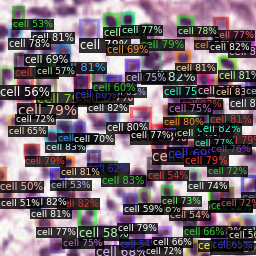

In [47]:
# Test with new image
new_im = cv2.imread("/kaggle/input/custom-dataset/selected_patches/patch_patient_004_node_4_x_10304_y_18272.png")
new_im = cv2.resize(new_im, (256, 256))
print(new_im.shape)

outputs = predictor(new_im)
instances = outputs["instances"].to("cpu")

confidence_threshold = 0.5
instances = instances[instances.scores > confidence_threshold]

v = Visualizer(new_im[:, :, ::-1], metadata=train_metadata, scale=1)
out = v.draw_instance_predictions(instances)

cv2_imshow(out.get_image()[:, :, ::-1])

# TODO

- Extracting cells number and density
- Create csv metadata file containing this infos
- Feature extraction 

In [ ]:
"""
# Directory path to the input images folder
input_images_directory = "/kaggle/input/camelyon/dataset/patches"

# Output directory where the segmented images will be saved
output_directory = "/kaggle/working/test_results/masks"  # Replace this with the path to your desired output directory
os.makedirs(output_directory, exist_ok=True)

# Loop over the images in the input folder
def process_images_in_directory(input_dir, output_dir):
    for root, _, files in os.walk(input_dir):
        for file in files:
            if file.endswith(('.png')): 
                image_path = os.path.join(root, file)
                new_im = cv2.imread(image_path)

                # Perform prediction on the new image
                outputs = predictor(new_im)  # Replace `predictor` with your initialized model

                # Use Visualizer to draw the predictions on the image
                v = Visualizer(new_im[:, :, ::-1], metadata=train_metadata)
                out = v.draw_instance_predictions(outputs["instances"].to("cpu"))

                # Create the output path, maintaining the folder structure
                relative_path = os.path.relpath(image_path, input_dir)
                result_path = os.path.join(output_dir, os.path.splitext(relative_path)[0] + "_result.png")
                os.makedirs(os.path.dirname(result_path), exist_ok=True)

                # Save the segmented image
                cv2.imwrite(result_path, out.get_image()[:, :, ::-1])
                print(f"Image at {image_path} processed")

# Process all images in the directory
process_images_in_directory(input_images_directory, output_directory)

print("Segmentation of all images in subfolders completed.")
"""

In [ ]:
"""
import csv
from skimage.measure import regionprops, label
import os
import time
import re 
import cv2

# Assuming you have already defined the 'predictor' object and loaded the model.
# Also, make sure 'metadata' is defined appropriately.

# Directory path to the input images folder
input_images_directory = "/kaggle/input/camelyon/dataset/patches"

# Output directory where the CSV file will be saved
output_csv_path = "/kaggle/working/test_results/output_objects.csv"  # Replace this with the path to your desired output CSV file
os.makedirs(os.path.dirname(output_csv_path), exist_ok=True)

# Gather all image paths
image_paths = []
for root, _, files in os.walk(input_images_directory):
    for file in files:
        if file.endswith(('.png')):  # Process only PNG files
            image_paths.append(os.path.join(root, file))

# Function to extract patient, node, x, and y coordinates from file name
def parse_filename(file_name):
    pattern = r"patch_patient_(\d+)_node_(\d+)_x_(\d+)_y_(\d+)"
    match = re.search(pattern, file_name)
    if match:
        patient = match.group(1)
        node = match.group(2)
        x_coord = match.group(3)
        y_coord = match.group(4)
        return patient, node, x_coord, y_coord
    else:
        return None, None, None, None

# Total number of images
total_images = len(image_paths)
print(f"Total Images: {total_images}")

# Open the CSV file for writing
with open(output_csv_path, 'w', newline='') as csvfile:
    csvwriter = csv.writer(csvfile)

    # Write the header row in the CSV file
    csvwriter.writerow(["patient", "node", "x_coord", "y_coord", "area", "centroid", "bounding_box", "number_of_cells", "cells_density"])  # Add more columns as needed

    start_time = time.time()  # Record the start time of the entire process

    # Loop over the images
    for idx, image_path in enumerate(image_paths):
        image_start_time = time.time()  # Start time for the current image
        new_im = cv2.imread(image_path)

        file_name = os.path.basename(image_path)
        patient, node, x_coord, y_coord = parse_filename(file_name)

        # Perform prediction on the new image
        outputs = predictor(new_im)  # Replace `predictor` with your initialized model

        # Convert the predicted mask to a binary mask
        mask = outputs["instances"].pred_masks.to("cpu").numpy().astype(bool)
        # Skip if the mask is empty
        if mask.size == 0 or not mask.any():
            print(f"Skipped {image_path} because the mask is empty.")
            continue

        # Get the predicted class labels
        class_labels = outputs["instances"].pred_classes.to("cpu").numpy()

        # Use skimage.measure.regionprops to calculate object parameters
        labeled_mask = label(mask)
        props = regionprops(labeled_mask)
        num_cells = len(props)
        mask_area = np.sum(mask)

        # Calculate cell density
        cell_density = num_cells / mask_area if mask_area > 0 else 0

        # Write the object-level information to the CSV file
        for i, prop in enumerate(props):
            object_number = i + 1  # Object number starts from 1
            area = prop.area
            centroid = prop.centroid
            bounding_box = prop.bbox

            # Check if the corresponding class label exists
            if i < len(class_labels):
                class_label = class_labels[i]
                class_name = train_metadata.thing_classes[class_label]
            else:
                class_name = 'Unknown'  # If class label is missing

            # Write the object-level information to the CSV file
            csvwriter.writerow([patient, node, x_coord, y_coord, area, centroid, bounding_box, num_cells, cell_density])

        # Calculate time taken for the current image
        image_time_taken = time.time() - image_start_time

        # Calculate estimated remaining time
        images_processed = idx + 1
        elapsed_time = time.time() - start_time
        avg_time_per_image = elapsed_time / images_processed
        remaining_time = avg_time_per_image * (total_images - images_processed)

        # Print progress
        print(f"Processed {images_processed}/{total_images} images. "
              f"Time for current image: {image_time_taken:.2f}s. "
              f"Estimated time remaining: {remaining_time:.2f}s.")

print("Object-level information saved to CSV file.")
"""